# Potassium Absorption

This notebook is compiles the best measurements of the potassium density from absorption spectroscopy

# Import statements and Initialization

In [ ]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.daq.nidaqmx_tools as ndaq
import one_ring.base.signal_tools as sit
import one_ring.base.pandas_tools as pdt
import importlib
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
%matplotlib widget
import time as tm
import one_ring.daq.visa_instruments as nvisa
plt.style.use("dark_background")
import pandas as pd
from importlib import reload

#import nidaqmx as ni
import pyvisa as visa
import one_ring.daq.thorlabs as thor
import one_ring.daq.stanford_research_systems as srs
file_name = "../data/absorption_measurements.h5"

### Useful constants 

In [26]:
outfname2 = "../data/hybrid_pumping.h5"
outfname = "../data/absorption_measurements.h5"

In [37]:
ih5paths = pdt.InteractiveHDF5Paths(outfname, 2)
ih5paths.display_widgets()

GridspecLayout(children=(Select(description='level_0', layout=Layout(grid_area='widget001'), options=('casper_…

Output()

In [38]:
ih5paths.final_path

'wulgang_2025_11_21/scan1'

# Wulgang K Absorption 2025

In [39]:
data_22degC = h5t.load_group(outfname, 'wulgang_2025_11_21/reference_scan')
data_80degC = h5t.load_group(outfname, 'wulgang_2025_11_21/scan1')

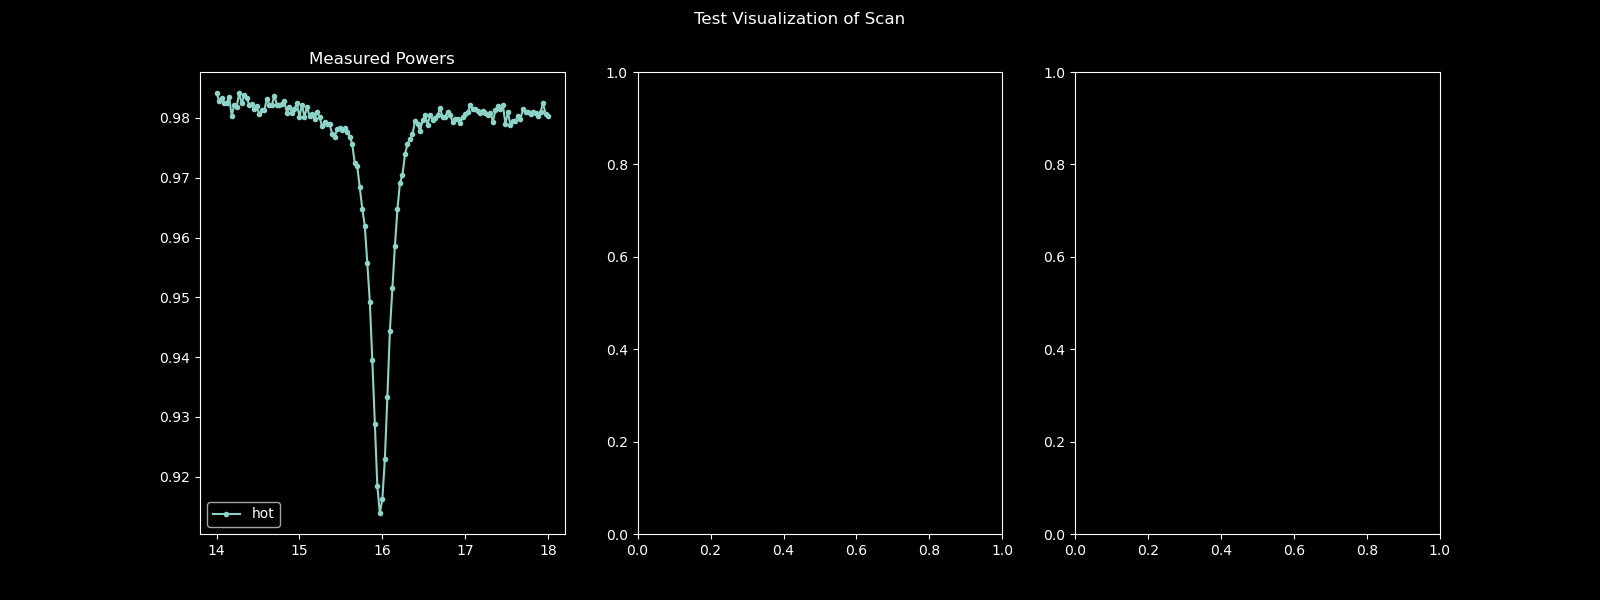

In [40]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

x_arr = data_22degC['temperature']
y_arr = data_22degC['power']
y2_arr = data_80degC['power']
transmission = y2_arr / y_arr
gain_normalizing = 1

ax.plot(x_arr.m, transmission.m   ,marker='.',label='hot',color='C0')

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
plt.show()

# Olaf K Absorption

In [3]:
#loading up 6 scans of calibration data

#Note that calibration curves 1-5, 11 were thrown out because of weird phase delays an spontaneous mode hops in the laser
data6 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_6")
data7 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_7")
data8 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_8")
data9 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_9")
data10 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_10")
data12 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_12")
data13 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_13")
data14 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_14")
data15 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_15")
data16 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_16")
data17 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_17")
data18 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_18")
data19 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_19")
data20 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_20")
data21 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_21")
data22 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_22")
data23 = h5t.load_group(outfname, "olaf_2025_07_31/K/calibration_curve_23")
data24 = h5t.load_group(outfname, "olaf_2025_07_31/K/calibration_curve_24")
data25 = h5t.load_group(outfname, "olaf_2025_07_31/K/calibration_curve_25")

data_c = np.array([data6,data7,data8,data9,data10,data12,data13,data14,data15,data16,data17,data18,data19,data20,data21,data22,data23,data24,data25])
h5t.get_node_metadata(outfname, "olaf_2025_07_25/K/calibration_curve_5")

{'misc_notes': 'Calibration curve measurement. cold cell , TWO powermeters, and beam sampler. freq and power measurements with WS-7 too.',
 'power_meter_head': 'S121C and S120C',
 'cell_temperature': <Quantity(30, 'degree_Celsius')>,
 'initial_settling_time': <Quantity(30, 'second')>,
 'power_meter_wavelength': <Quantity(770.0, 'nanometer')>,
 'probe_laser_current': <Quantity(55.0, 'milliampere')>,
 'settling_time_scan': <Quantity(2, 'second')>}

In [4]:
#selecting the largest minimum and smallest maximum so that interpolator is within range of all data
f_min = data_c[max(np.arange(data_c.size), key = lambda i: data_c[i]['freq'][-1])]['freq'][-1]
f_max =data_c[min(np.arange(data_c.size), key = lambda i: data_c[i]['freq'][0])]['freq'][0]

#assuming a common x-range for now
num_steps = 200
common_freq_array = np.linspace(f_min, f_max, num_steps)

#defining reference and transmission interpolators
ref_interp = [None] * data_c.size
trans_interp = [None] * data_c.size
for i, data_set in enumerate(data_c):
    ref_interp[i] = scipy.interpolate.interp1d(data_set['freq'].m, data_set['ref'].m, kind = 'linear')
    trans_interp[i] = scipy.interpolate.interp1d(data_set['freq'].m, data_set['hot'].m, kind = 'linear')

C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\scipy\_lib\_util.py:321: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = toarray(a)
C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


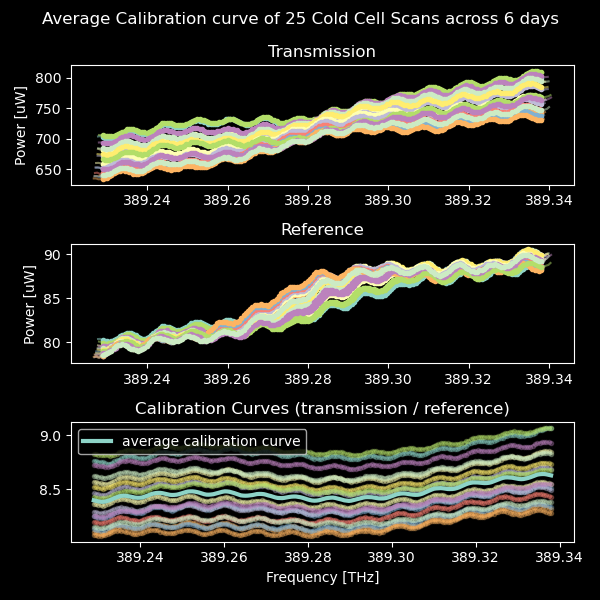

In [5]:
fig, axes = plt.subplots(figsize=(6,6),nrows=3)
ax, ax1, ax2 = axes

#defining a average caibration curve of assumed length
calib_avg = common_freq_array.m*0

for i,m in enumerate(data_c):
    #omitting bad data
    omit_data = np.array([3,10])
    if (np.isin(i,omit_data)):
        continue
        
    #plotting transmission power
    ax.plot(common_freq_array.m, trans_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax.plot(m['freq'], m['hot'], color='C'+str(i), alpha=0.5)
    #plotting reference power
    ax1.plot(common_freq_array.m, ref_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax1.plot(m['freq'], m['ref'], color='C'+str(i), alpha=0.5)
    #plotting calibration curves
    ax2.plot(common_freq_array.m, trans_interp[i](common_freq_array) / ref_interp[i](common_freq_array), color='C'+str(i), marker='.',alpha=0.3)
    #ax2.plot(m['freq'], m['hot'] / m['ref'], color='C'+str(i), alpha=0.5, marker='^')
    #defining average calibration
    calib_avg += trans_interp[i](common_freq_array) / ref_interp[i](common_freq_array) / (data_c.size - omit_data.size) 
    
ax2.plot(common_freq_array.m, calib_avg,linewidth=3,label='average calibration curve')

plt.suptitle('Average Calibration curve of 25 Cold Cell Scans across 6 days')
ax.set_title('Transmission')
ax1.set_title('Reference')
ax2.set_title('Calibration Curves (transmission / reference)')
ax1.set_ylabel('Power [uW]')
ax.set_ylabel('Power [uW]')
ax2.legend()
ax2.set_xlabel('Frequency [THz]')
plt.tight_layout()
plt.show()

In [6]:
h5t.get_node_metadata(outfname,"olaf_2025_07_29/K/absorption_12")

{'misc_notes': 'Calibration curve measurement. hot cell , TWO powermeters, and beam sampler. freq and power measurements with WS-7 too. same configuration as those made 1 days ago on MOnday',
 'power_meter_head': 'S121C and S120C',
 'cell_temperature': <Quantity(190, 'degree_Celsius')>,
 'initial_settling_time': <Quantity(30, 'second')>,
 'power_meter_wavelength': <Quantity(770.0, 'nanometer')>,
 'probe_laser_current': <Quantity(55.0, 'milliampere')>,
 'settling_time_scan': <Quantity(2, 'second')>}

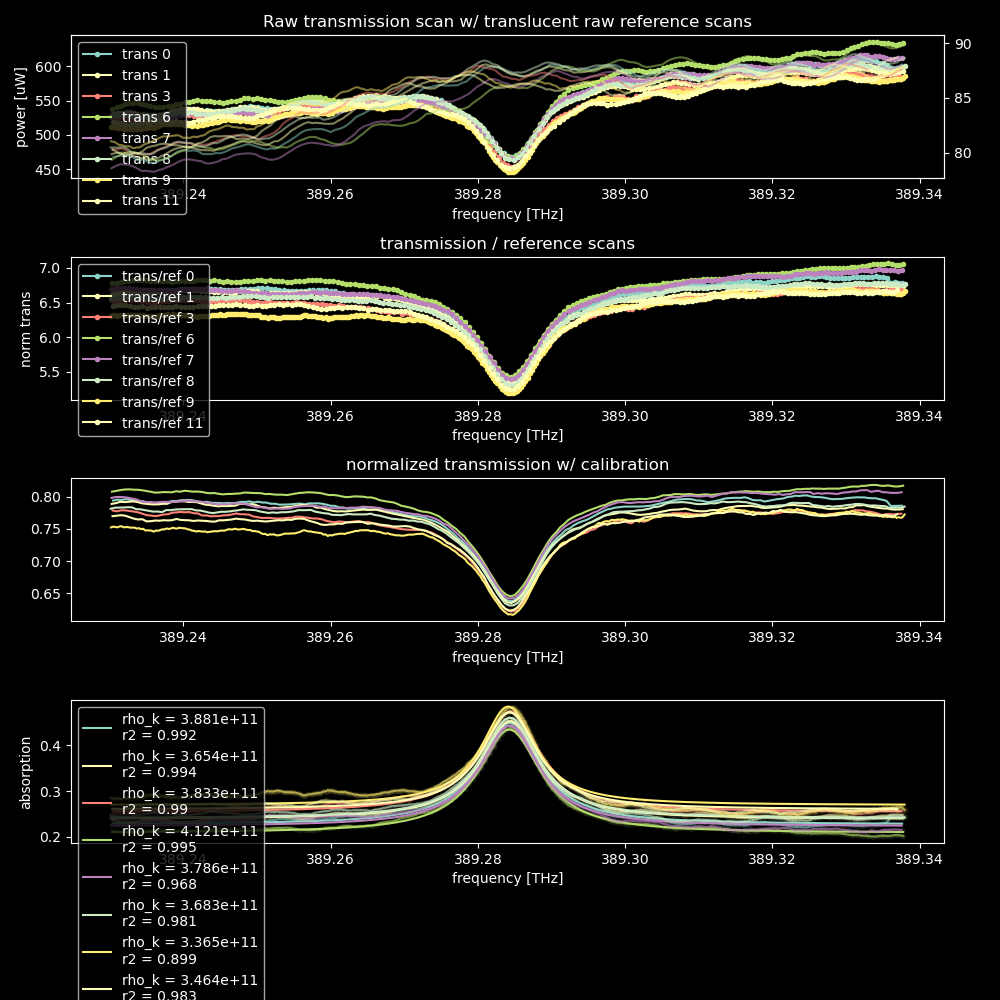

In [7]:
fig, axes = plt.subplots(nrows=4,figsize=(10,10))

ax0, ax1, ax2,ax3 = axes
ax01 = ax0.twinx()

data1=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_1")
data2=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_2")
data3=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_3") #jumping but usable data
data4=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_4")
data5=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_5") #jumpnig but usable data
data6=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_6") #bad data, remove when at like 100 degC
data7=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_7")
data8=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_8") #lights off
data9=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_9") #magnetic bias and lights back on
data10=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_10") #double the amount of points and magnetic bias off
data11=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_11") #bad data, remove
data12=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_12")
data_h = np.array([data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12])
#data_h = np.array([data4])
ax0_lns = []
ax1_lns = []
#omit_data = np.array([0,1,2,3,4,5,7,8,9,10,11])
omit_data = np.array([2,4,5,10])
data_density = np.zeros(data_h.size)
data_hwhm = np.zeros(data_h.size)
data_f0 = np.zeros(data_h.size)

for i,data_h_m in enumerate(data_h):
    if (np.isin(i,omit_data)):
        continue
    mask = (data_h_m['freq'].m>389.23) * (data_h_m['freq'].m<389.338)
    freq = data_h_m['freq'][mask]
    output = data_h_m['hot'][mask]
    ref = data_h_m['ref'][mask]
    
    #calculate the average calibration curve my interpolating based on x-axis of hot scan
    calib_avg = freq.m * 0
    for j,m in enumerate(data_c):
        calib_avg += trans_interp[j](freq) / ref_interp[j](freq)/(data_c.size)
    
    #RAW TRANSMISSION PLOT
    ln1 = ax0.plot(freq, output, marker='.', label='trans ' + str(i), color='C'+str(i))
    ln2 = ax01.plot(freq, ref, label='ref ' + str(i),color='C'+str(i),alpha=0.5)
    ax0_lns += ln1
    
    #NORMALIZED PLOT
    ln3 = ax1.plot(freq, output/ref, marker='.', label='trans/ref ' + str(i), color='C'+str(i))
    #ln4 = ax1.plot(freq, calib_avg, marker='.', label='calib' + str(i), color='C'+str(i))
    ax1_lns += ln3 
    
    #CALIBRATED PLOT
    ln4 = ax2.plot(freq, output/ref/calib_avg, label='trans/ref/calib ' + str(i), color = 'C' + str(i))
    
    #ABS PLOT
    normalized_transmission = output/ref/calib_avg
    ln5 = ax3.plot(freq, -np.log((normalized_transmission)), color='C'+str(i),alpha=0.6)
    
    abs_fitter =fitt.AbsorptiveLorentzianFitter()
    fit_result = abs_fitter.fit(freq.m, -np.log(normalized_transmission).m,guess = [0.07,389.228,0.144,0.05])
    A = fit_result.fit_parameters['A']
    f0 = fit_result.fit_parameters['f0']
    HWHM = fit_result.fit_parameters['HWHM']
    Offset = fit_result.fit_parameters['Offset']
    
    #DENSITY CALCULATION
    HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
    c = scipy.constants.c*ureg.m/ureg.s
    cross_section_on_resonance = pt.c*pt.r_e*pt.f_K/ (HWHM_freq)
    cross_section_on_resonance.to(ureg.cm**2)
    L = 1 * ureg.cm
    #absorbance_resonance = -np.log(normalized_transmission.min() / normalized_transmission.max()) #close approximation but better to work with the fit rather than the data.
    #absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM'] #do not include offset, as that isnt physical.
    absorbance_resonance = (A / HWHM) - A * HWHM / (f0**2 + HWHM**2) #small minor negligble change, consider as log(P/P0) on resonance minus log(P/P0) off resonance
    density_K = absorbance_resonance / (L * cross_section_on_resonance)
    data_density[i] = density_K.to(1/ureg.cm**3).m
    data_hwhm[i] = HWHM
    data_f0[i] = f0
 
    fit_result.plot_fit(ax=ax3,dkwargs={"color":'C' + str(i), "alpha":0.1, "label":'_nolegend_'},
                        fkwargs={"color":'C' + str(i), "label":"rho_k = {:.3e}\nr2 = {:.3}".format(density_K.to(1/ureg.cm**3).m,fit_result.r2)})
    
ax0.legend(ax0_lns, [l.get_label() for l in ax0_lns], loc = 0)
ax1.legend(ax1_lns, [l.get_label() for l in ax1_lns], loc = 0)
ax0.set_title('Raw transmission scan w/ translucent raw reference scans')
ax1.set_title('transmission / reference scans')
ax0.set_ylabel('power [uW]')
ax1.set_ylabel('norm trans')
ax2.set_title('normalized transmission w/ calibration')
ax3.set_ylabel('absorption')
plt.setp(axes,xlabel='frequency [THz]')
plt.tight_layout()
plt.show()

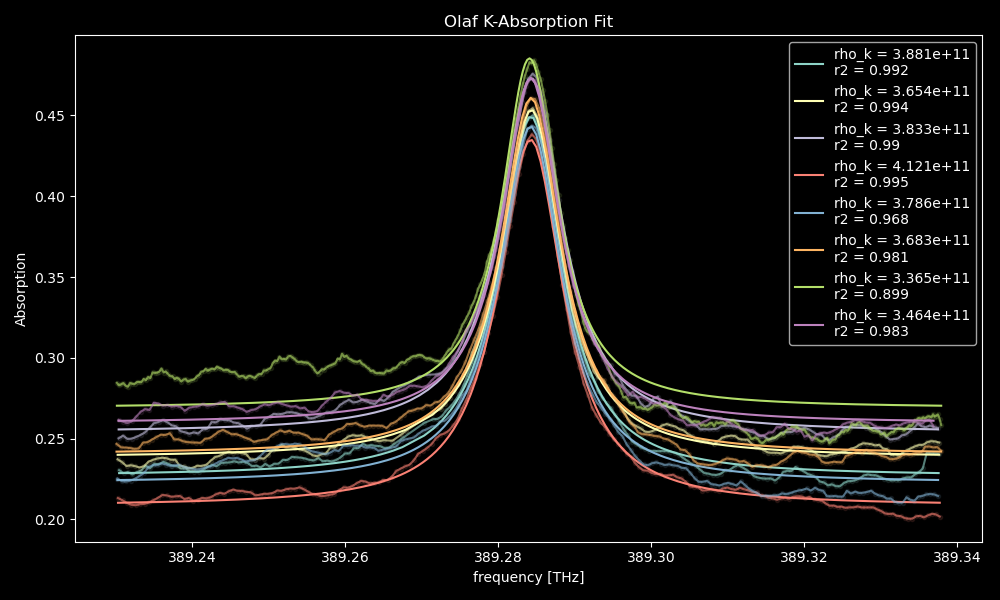

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

#hot cell transmission datas absorption 3,5,6,11 were remved for mode hopes, and weird throwable data
data1=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_1")
data2=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_2")
data4=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_4")
data7=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_7")
data8=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_8") #lights off
data9=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_9") #magnetic bias and lights back on
data10=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_10") #double the amount of points and magnetic bias off
data12=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_12")
data_h = np.array([data1,data2,data4,data7,data8,data9,data10,data12])

data_density = np.zeros(data_h.size)
data_hwhm = np.zeros(data_h.size)
data_f0 = np.zeros(data_h.size)

for i,data_h_m in enumerate(data_h):
    mask = (data_h_m['freq'].m>389.23) * (data_h_m['freq'].m<389.338)
    freq = data_h_m['freq'][mask]
    output = data_h_m['hot'][mask]
    ref = data_h_m['ref'][mask]
    
    #calculate the average calibration curve my interpolating based on x-axis of hot scan
    calib_avg = freq.m * 0
    for j,m in enumerate(data_c):
        calib_avg += trans_interp[j](freq) / ref_interp[j](freq)/(data_c.size)
    
    #ABS PLOT
    normalized_transmission = output/ref/calib_avg
    ln5 = ax.plot(freq, -np.log((normalized_transmission)), color='C'+str(i),alpha=0.6)
    
    abs_fitter =fitt.AbsorptiveLorentzianFitter()
    fit_result = abs_fitter.fit(freq.m, -np.log(normalized_transmission).m,guess = [0.07,389.228,0.144,0.05])
    A = fit_result.fit_parameters['A']
    f0 = fit_result.fit_parameters['f0']
    HWHM = fit_result.fit_parameters['HWHM']
    Offset = fit_result.fit_parameters['Offset']
    
    #DENSITY CALCULATION
    HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
    c = scipy.constants.c*ureg.m/ureg.s
    cross_section_on_resonance = pt.c*pt.r_e*pt.f_K/ (HWHM_freq)
    cross_section_on_resonance.to(ureg.cm**2)
    L = 1 * ureg.cm
    absorbance_resonance = (A / HWHM) - A * HWHM / (f0**2 + HWHM**2) #small minor negligble change, consider as log(P/P0) on resonance minus log(P/P0) off resonance
    density_K = absorbance_resonance / (L * cross_section_on_resonance)
    data_density[i] = density_K.to(1/ureg.cm**3).m
    data_hwhm[i] = HWHM
    data_f0[i] = f0
 
    fit_result.plot_fit(ax=ax,dkwargs={"color":'C' + str(i), "alpha":0.1, "label":'_nolegend_'},
                        fkwargs={"color":'C' + str(i), "label":"rho_k = {:.3e}\nr2 = {:.3}".format(density_K.to(1/ureg.cm**3).m,fit_result.r2)})
    
plt.title('Olaf K-Absorption Fit')
plt.xlabel('frequency [THz]')
plt.ylabel('Absorption')
plt.tight_layout()
plt.show()

In [9]:
fit_result.fit_error

{'A': 1.533772503858394e-05,
 'f0': 5.428304445237542e-05,
 'HWHM': 8.855787901094687e-05,
 'Offset': 0.0006052831620615266}

In [10]:
data_hwhm * ureg.THz

Magnitude,[0.00497707533348269 0.004846343545768416 0.004988257506271802 0.005187212474941772 0.004898266469382376 0.004766005350470487 0.004439257260306399 0.004623751227256994]
Units,terahertz


In [11]:
def quote_stat(data,precision):
    print(('Average = {:.' + str(precision) + 'e} +/- {:.' + str(precision) + 'e} {}' ).format(data.mean().m,data.std().m, data.u))

In [12]:
quote_stat(data_density*ureg.cm**-3,3)
quote_stat(data_f0*ureg.THz,8)
quote_stat((data_hwhm*ureg.THz).to(ureg.GHz),3)

Average = 3.723e+11 +/- 2.239e+10 1 / centimeter ** 3
Average = 3.89284280e+02 +/- 6.70832433e-05 terahertz
Average = 4.841e+00 +/- 2.173e-01 gigahertz


In [13]:
data_hwhm

array([0.00497708, 0.00484634, 0.00498826, 0.00518721, 0.00489827,
       0.00476601, 0.00443926, 0.00462375])

# Wulfgang K Absorption 2023

In [30]:
#loading raw data
ref_grp = "wulgang_15_02_2023/bg_1"
scan_grp = "wulgang_15_02_2023/scan_1"

tf_df = pdt.load_dataframe(outfname, "casper_12_30_2022/background")
ref_df = pdt.load_dataframe(outfname, ref_grp)
scan_df = pdt.load_dataframe(outfname, scan_grp)

#normalizing the transmission
scan_df["normalized_transmission"] = (scan_df["transmitted_power_(V)"]/ (scan_df["initial_power_(V)"]))
#putting in absorption transformation
scan_df["absorption_xc_(au)"] = -np.log(scan_df["normalized_transmission"])
#x-axis calibration
fit_result_calib = fitt.fit_line(tf_df.index.to_numpy(), tf_df["frequency_(THz)"].to_numpy())
slope = fit_result_calib.fit_parameters['slope']
intercept = fit_result_calib.fit_parameters['intercept']
#fitting absorption
fitter = fitt.AbsorptiveLorentzianFitter()
#plotting with frequency x axis
#fit_result_abs = fitter.fit(scan_df.index.to_numpy()*slope + intercept, scan_df["absorption_xc_(au)"].to_numpy())
#plotting with temperature x axis
fit_result_abs = fitter.fit(scan_df.index.to_numpy(), scan_df["absorption_xc_(au)"].to_numpy())

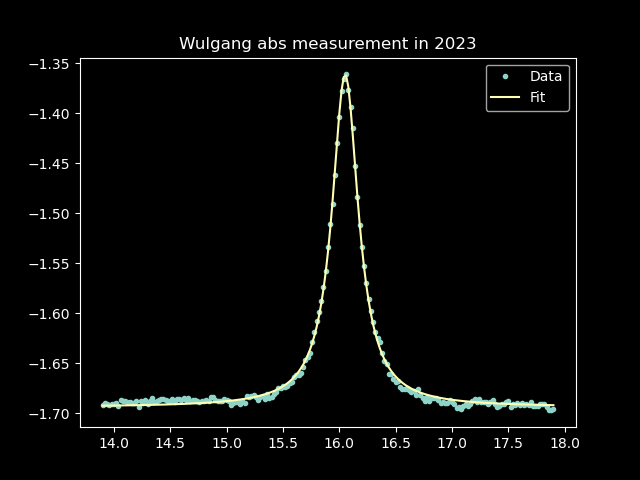

{'A': 0.047445727597989575,
 'f0': 16.052301626802304,
 'HWHM': 0.14263656894720675,
 'Offset': -1.693853071542804}

In [31]:
plt.figure()
fit_result_abs.plot_fit()
plt.title('Wulgang abs measurement in 2023')
plt.show()
fit_result_abs.fit_parameters

In [32]:
#density estimation
cs_on_resonance = at.cross_section(fit_result_abs.fit_parameters['HWHM'],'K/D1')
a = pt.absorption(fit_result_abs)
L = 1.8*ureg.cm

prefactor = fit_result_abs.fit_parameters['HWHM']*ureg.THz / (pt.c*pt.r_e*pt.f_K)
n = (a/(cs_on_resonance*L)).to(ureg.cm**-3)
print('density = {:.3e}'.format(n))

NameError: name 'c' is not defined

In [18]:
16.052 + 0.85

16.902